In [139]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, splu
from tqdm import tqdm
%run PropagationEnvironment.ipynb

class ParabolicWaveEquationSolver(PropagationEnvironment):
    """
    Optimized IFD solver with LU factorization caching and vectorized operations.
    """
    
    def __init__(self, f, c_0, z_0=None, r_max=None, z_lims=None, 
                 roughness=None, topography=None, ssp=None, rho=None, 
                 alpha=None, measurement_points=None, ssp_directory=None):
        """
        Pre-compute all range-independent quantities and cache factorizations.
        
        INPUTS
        f: frequency in [Hz]
        r: r values in [m]
        z: z values in [m]
        c: array of sound speed values in [m/s]
        alpha: array of attenuation values in [dB/lambda]
        theta: slope of the bottom in [rad]
        rho: array of density at each point in the ocean [kg/m^3]
        """

        super().__init__(f, c_0, z_0, r_max, z_lims, 
                 roughness, topography, ssp, rho, 
                 alpha, measurement_points, ssp_directory)
        
        # Reference parameters
        self.rho_0 = self.rho[0, 0]
        self.k_0 = 2 * np.pi * f / self.c_0
        
        # Pre-compute refractive index (range x depth)
        self.refractive_index = (self.c_0 / self.ssp)**2 + 1j * (self.c_0 / self.ssp)**2 * self.alpha / 27.287527
        
        # Pre-allocate result array
        self.u = np.zeros((len(self.r_mesh), len(self.z_mesh)), dtype=complex)
        
        # Cache for LU factorizations
        self.lu_cache = {}
        self.check_factorization_reuse()
        
    def check_factorization_reuse(self):
        """
        Determine if factorizations can be reused across range steps.
        If environment is range-independent, we only need one factorization.
        """
        # Check if c, alpha, rho are range-independent
        c_varies = np.any(np.diff(self.ssp, axis=0) != 0)
        alpha_varies = np.any(np.diff(self.alpha, axis=0) != 0)
        rho_varies = np.any(np.diff(self.rho, axis=0) != 0)
        
        self.range_independent = not (c_varies or alpha_varies or rho_varies)
        
        if self.range_independent:
            print("Range-independent environment detected: will reuse factorization")
        else:
            print("Range-dependent environment: will compute factorizations as needed")
    
    def build_system_matrices(self, nn):
        """
        Build the sparse tridiagonal matrices A and B for range step nn.
        Optimized with vectorized operations and sparse matrix construction.
        
        Returns A, B as CSR sparse matrices.
        """

        k = self.r_mesh[nn+1] - self.r_mesh[nn]
        
        # Vectorized computation of main diagonals
        a = 1j / 2 * self.k_0 * (self.refractive_index**2 - 1)
        b = 1j / (2 * self.k_0) * np.ones_like(self.refractive_index)
        
        # Slicing for interior points (avoid repeated indexing)
        rho_1_2 = self.rho[:, 1:-2]  # ρ(j-1)
        rho_2_1 = self.rho[:, 2:-1]  # ρ(j)
        b_mid = b[:, 1:-1]
        a_mid = a[:, 1:-1]
        
        # Vectorized P and Q calculations
        P = 1 / (1/b_mid + (rho_1_2 / rho_2_1) * (1/b_mid))
        Q = a_mid / b_mid + (rho_1_2 / rho_2_1) * (a_mid / b_mid)
        
        # Vectorized X and Y calculations
        h2_over_kP = self.h**2 / (k * P)
        h2_over_2Q = self.h**2 / 2 * Q
        rho_ratio = rho_1_2 / rho_2_1
        
        X = h2_over_kP - (h2_over_2Q - (rho_ratio + 1))
        Y = h2_over_kP + (h2_over_2Q - (rho_ratio + 1))
        
        # Bottom boundary conditions (vectorized)
        theta_val = 0  # Can make this variable if needed
        bottom_c = b_mid * np.tan(theta_val) / (self.h - b_mid * np.tan(theta_val))
        bottom_d = (np.tan(theta_val) * (a_mid + 1j * self.k_0) - 2 * b_mid / self.h**2) / \
                   (1/self.h - b_mid * np.tan(theta_val) / self.h**2)
        
        # Matrix size
        M = len(self.z_mesh) - 2
        
        # Build sparse matrices efficiently using diags
        # Matrix A (nn+1)
        main_diag_A = X[nn+1, :]
        upper_diag_A = -rho_1_2[nn+1, :-1] / rho_2_1[nn+1, :-1]
        lower_diag_A = -np.ones(M - 1)
        
        # Modify last elements for bottom BC
        main_diag_A[-1] += bottom_d[nn+1, -1]
        lower_diag_A[-1] += bottom_c[nn+1, -1]
        
        A = sp.diags(
            [lower_diag_A, main_diag_A, upper_diag_A],
            offsets=[-1, 0, 1],
            shape=(M, M),
            format='csr'
        )
        A = A.tolil()
        A = A.tocsr()
        
        # Matrix B (nn)
        main_diag_B = Y[nn, :]
        upper_diag_B = rho_1_2[nn, :-1] / rho_2_1[nn, :-1]
        lower_diag_B = np.ones(M - 1)
        
        # Modify last elements for bottom BC
        main_diag_B[-1] -= bottom_d[nn, -1]
        lower_diag_B[-1] -= bottom_c[nn, -1]
        
        B = sp.diags(
            [lower_diag_B, main_diag_B, upper_diag_B],
            offsets=[-1, 0, 1],
            shape=(M, M),
            format='csr'
        )
        B = B.tolil()
        B = B.tocsr()
        
        return A, B
    
    def solve(self, u0_func, z_s):
        """
        Solve the parabolic equation with optimized range marching.
        
        INPUTS
        u0_func: function to generate initial field u0(z, z_s, k_0, k)
        z_s: depth of source
        
        RETURNS
        u: complex field array (range x depth)
        """
        
        # Initialize field
        self.u[0, :] = u0_func(self.z_mesh, z_s, self.k_0)
        z_mesh = self.z_mesh
        self.u[0, z_mesh > self.topography[0]] = 0
        
        # Pre-compute factorization for range-independent case
        lu_factorization = None
        B_matrix = None
        
        if self.range_independent:
            print("Pre-computing LU factorization...")
            A, B_matrix = self.build_system_matrices(0)
            lu_factorization = splu(A.tocsc())
            print("Factorization complete. Starting range march...")
        
        # Range marching loop
        pbar = tqdm(total=len(self.r_mesh) - 1, position=0, leave=True)
        
        for nn in range(len(self.r_mesh) - 1):
            if self.range_independent:
                # Reuse cached factorization
                lu = lu_factorization
                B = B_matrix
            else:
                # Check cache for this range step
                if nn in self.lu_cache:
                    lu, B = self.lu_cache[nn]
                else:
                    A, B = self.build_system_matrices(nn)
                    lu = splu(A.tocsc())
                    # Cache if memory allows (limit cache size for very long ranges)
                    if len(self.lu_cache) < 100:
                        self.lu_cache[nn] = (lu, B)
            
            # Compute RHS: B @ u[nn, 1:-1]
            rhs = B @ self.u[nn, 1:-1]
            
            # Solve: A @ u[nn+1, 1:-1] = rhs
            self.u[nn+1, 1:-1] = lu.solve(rhs)
            
            # Apply topography mask if needed
            if self.topography is not None:
                self.u[nn+1, z_mesh > self.topography[nn+1]] = 0
            
            pbar.update(1)
        
        pbar.close()
        
        return self.u

    def plot(self):

        fig, ax = plt.subplots(figsize = (15,5))
        im = ax.pcolormesh(self.r_mesh, self.z_mesh, np.transpose(20*np.log10(np.abs(self.u/np.max(self.u[0,:])))), vmin = -60, shading='gouraud')
        ax.plot(self.r_mesh, self.topography, 'w')
        ax.invert_yaxis()
        ax.set_ylabel('Depth (m)')
        ax.set_xlabel('Range (m)')
        cbar = fig.colorbar(im, ax=ax, label='TL (dB)')
        
        plt.savefig('Figures/sample_figure.png')


In [155]:
solver = ParabolicWaveEquationSolver(
    f = 250,
    c_0 = 1500,
    z_0 = 1000,
    r_max = 5000,
    z_lims = [200, 1500],
    roughness = 3)

Mesh created: 5522 range × 539 depth points
Environment initialized: 5522 × 539 grid
Range-dependent environment: will compute factorizations as needed


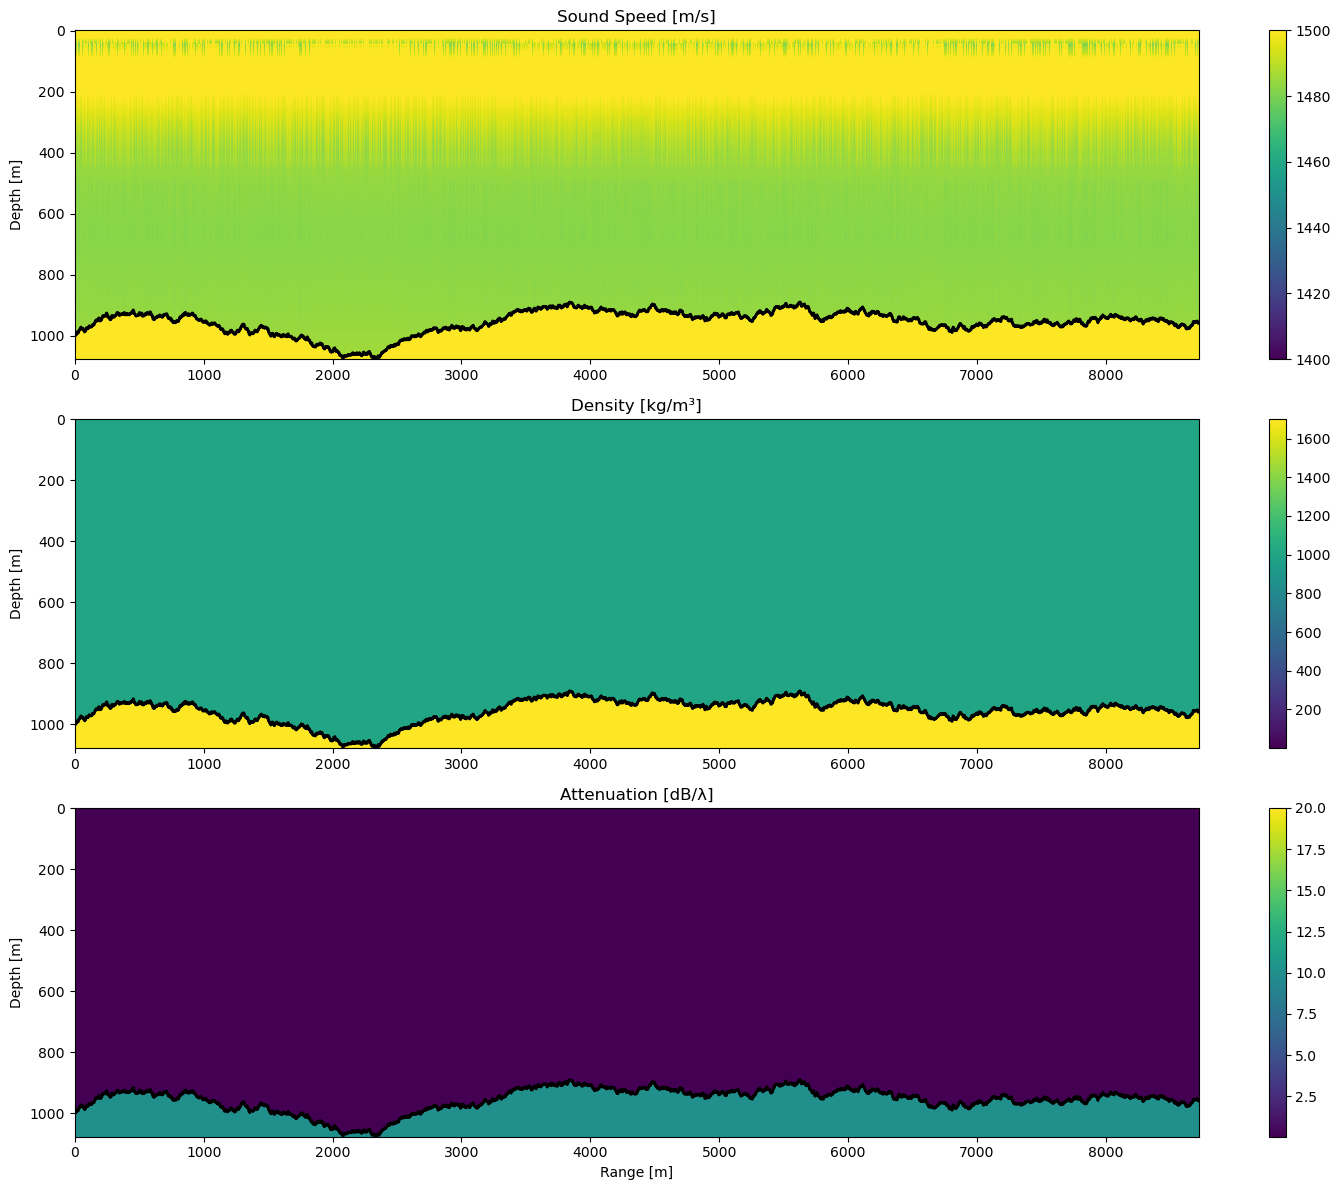

In [157]:
solver.plot_environment()

  0%|                                                  | 0/5521 [00:00<?, ?it/s]/var/folders/mq/knq1z06s5zn3lq38hcwfcv900000gn/T/ipykernel_90220/3893960916.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  lower_diag_A[-1] += bottom_c[nn+1, -1]
/var/folders/mq/knq1z06s5zn3lq38hcwfcv900000gn/T/ipykernel_90220/3893960916.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  lower_diag_B[-1] -= bottom_c[nn, -1]
100%|█████████████████████████████████████| 5521/5521 [1:10:38<00:00,  1.30it/s]
/var/folders/mq/knq1z06s5zn3lq38hcwfcv900000gn/T/ipykernel_90220/3893960916.py:208: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(self.r_mesh, self.z_mesh, np.transpose(20*np.log10(np.abs(self.u/np.max(self.u[0,:])))), vmin = -60, shading='gouraud')


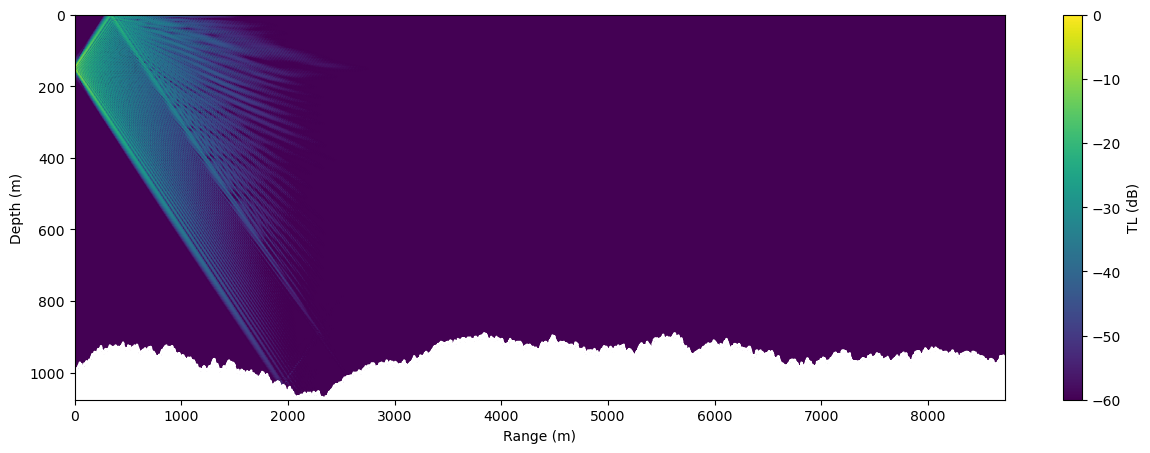

In [159]:
def u0_gaussian(z, G_w = 0.5, G_a = 1, z_s = 100):
    return G_a*(np.exp(-((z - z_s)/G_w)**2) - np.exp(-((-z - z_s)/G_w)**2))

def u0_monopole(z, z_s, k_0):
    u_0 = 1/(1 + (z - z_s)**2)*np.exp(1j*k_0*np.sqrt(1 + (z - z_s)**2))
    return u_0
    
solver.solve(u0_monopole, z_s = 150)
solver.plot()